In [1]:
import numpy as np               # Numpy for mathematical operations
import astropy.io.fits as fits   # Astropy for interpreting FITS files
import matplotlib.pyplot as plt  # Matplotlib for plot
import os                        # OS for handling large amounts of files

%matplotlib inline

## USB 2000 Data Reduction:

In [2]:
pix_He, int_He = np.genfromtxt('./Lab2Files/groupc-Helium02197.txt', usecols = [0,1], unpack=True, skip_header = 17, skip_footer = 1)
# Array of values for each column of chosen helium spectrum file

Text(0.5, 1.0, 'USB 2000 Helium Spectrum')

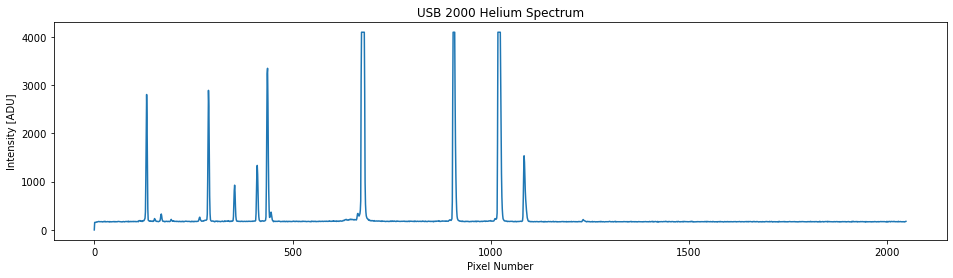

In [3]:
f = plt.figure()
f.set_figwidth(16)         # Setting plot to be wide to better vizualize
f.set_figheight(4)
plt.plot(pix_He, int_He)   # Plot of helium spectrum
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('USB 2000 Helium Spectrum')

In [4]:
mew = np.mean(int_He)
mask = np.where(int_He > mew*2, 1, 0)  # Using a mask to define peaks as having a minimum height requirement of 2x
                                       # mean intensity in order to specify only the most prominent spectral features
pix_masked = []
tmp_peak = []
for i, mask_val in enumerate(mask):
    if mask_val == 1:
        tmp_peak.append((pix_He[i], int_He[i]))  # List of pixel values and intensities
    elif len(tmp_peak) > 0:
            pix_masked.append(tmp_peak)        # Appending values where peak exists
            tmp_peak = []

In [5]:
centroids = []
sig_p = []

# Creating an array of centroid values and on of associated error for each peak according to equations shown below

for peak in pix_masked:
    numerator = sum([a*b for a, b in peak])
    denom = sum([b for a, b in peak])
    x_c = numerator / denom
    centroids.append(x_c)
    
for i, peak in zip(centroids, pix_masked):
    errnum = sum([b*(a-i)**2 for a, b in peak])
    errdenom = sum([b for a, b in peak])
    err = errnum / errdenom
    sig_p.append(np.sqrt(err))

In [6]:
centroids = np.array(centroids)  # Converting centroids and error to an array for easier numpy operations
sig_p = np.array(sig_p)

$$ p_c = \frac{\sum_{i=1}^{N}p_i I_i}{\sum_{i=1}^{N}I_i} $$

$$ \sigma_{p_c}^2 = \frac{\sum_jI_j(p_j-p_c)^2}{(\sum_iI_i)^2} $$

($ p_c $ is the pixel centroid value, $ p_i $ are pixel values in the peak, and $ I_i $ are corresponding intensity values)

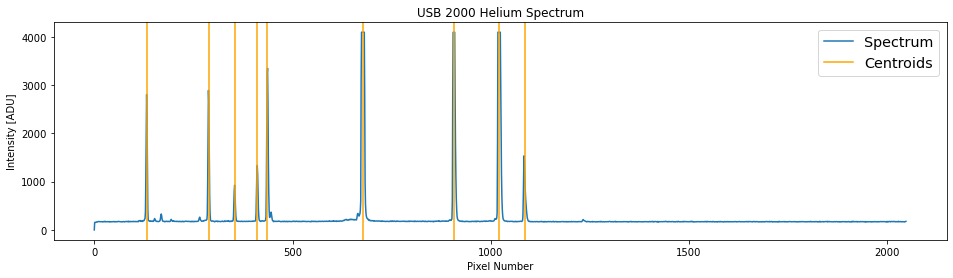

In [7]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(pix_He, int_He)
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('USB 2000 Helium Spectrum')
for i in centroids:
    plt.axvline(x = i, c = 'orange')    # Plotting centroids over helium spectrum
plt.legend(['Spectrum', 'Centroids'], fontsize='x-large')

## Linear least squares solution:

$$\begin{pmatrix} m \\ c \end{pmatrix} = \begin{pmatrix} \sum_{i=1}^{N} p_{i}^2 & \sum_{i=1}^{N} p_{i} \\ \sum_{i=1}^{N} p_{i} & N \end{pmatrix}^{-1}\begin{pmatrix} \sum_{i=1}^{N} p_{i}\lambda_{i} \\ \sum_{i=1}^{N} \lambda_{i} \end{pmatrix} $$

( m is slope of best fit, c is intercept of best fit, $ p_i $ are pixel centroids, N is number of centroid values, and $ \lambda_i $ are wavelengths )


In [8]:
wl_He = [394., 416., 427., 441., 469., 502., 589., 668., 710.] # https://edisciplinas.usp.br/pluginfile.php/4822251/mod_resource/content/1/Espectro%20do%20helio%20-%20presto.pdf
wl_He = np.array(wl_He)  # Converting wavelengths to an array for easier numpy operations

In [9]:
N = len(centroids)     # Number of centroid values for N input below

M1 = np.array([[np.sum((centroids)**2), np.sum(centroids)],[np.sum(centroids), N]])  # First matrix on right hand side
M2 = np.array([[np.sum(centroids*wl_He)],[np.sum(wl_He)]])  # Second matrix on right hand side

In [10]:
M1_inv = np.linalg.inv(M1)  # Inverse of first matrix
M = np.dot(M1_inv, M2)      # Dot product of two matrices for final result matrix

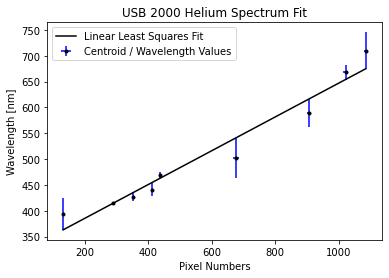

In [11]:
mfit = M[0,0]                           # Slope value from final matrix
cfit = M[1,0]                           # Intercept value from final matrix
y = [mfit*a + cfit for a in centroids]  # Linear least squares best-fit line
xerr = sig_p**2                         # Centroid standard deviation
yerr = np.absolute(y - wl_He)           # Error of each point from the best-fit line

plt.errorbar(centroids, wl_He, xerr=xerr, yerr=yerr, fmt='.', mfc='k', mec='k', ecolor='b', label = 'Centroid / Wavelength Values')
plt.plot(centroids, y, 'k' , label='Linear Least Squares Fit')
                                        # Fit line plotted over centroid points
plt.title('USB 2000 Helium Spectrum Fit')
plt.ylabel('Wavelength [nm]')
plt.xlabel('Pixel Numbers')
plt.legend()

In [19]:
print('Average std. dev. in x:', np.mean(xerr))  # Average standard deviations
print('Average std. dev. in y:', np.mean(yerr))

Average std. dev. in x: 3.877790915221302
Average std. dev. in y: 19.69746367361045


In [20]:
sig = np.sqrt(1/(N-2) * np.sum((wl_He - y)**2))
print('Gaussian std. dev. of fit:', sig**2) 
# Overall Gaussian standard deviation of fit according to equation below

Gaussian std. dev. of fit: 715.7441031833423


$$ \sigma^2 = \sum_j \sigma_j^2 = \frac{1}{N-2}\sum_i (\sigma_i - (mp_i+c))^2 $$

In [21]:
sig_M = np.sqrt((N*sig**2) / ((N*np.sum((centroids)**2))-(np.sum(centroids))**2))
print('Std. dev. of slope:', sig_M**2)  # Slope standard deviation

Std. dev. of slope: 0.0007518610783739511


$$ \sigma_m^2 = \frac {N\sigma^2}{N \sum_i^Np_i^2-(\sum_i^Np_i^2)^2} $$

In [22]:
sig_c = np.sqrt((sig**2*np.sum((centroids)**2)) / ((N*np.sum((centroids)**2))-(np.sum(centroids))**2))
print('Std. dev. of intercept:', sig_c**2)  # Intercept standard deviation

Std. dev. of intercept: 341.6321817355492


$$ \sigma_c^2 = \frac {\sigma^2\sum_i^Np_i^2}{N \sum_i^Np_i^2-(\sum_i^Np_i^2)^2} $$

In [23]:
def pix_to_wl(p):       # Conversion from pixel position to wavelength using linear least squares fit
    wl = p*mfit + cfit
    return wl

In [24]:
wl_x = []

for i in pix_He:      # Creating array of converted wavelengths
    w = pix_to_wl(i)
    wl_x.append(w)

Text(0.5, 1.0, 'USB 2000 Helium Spectrum')

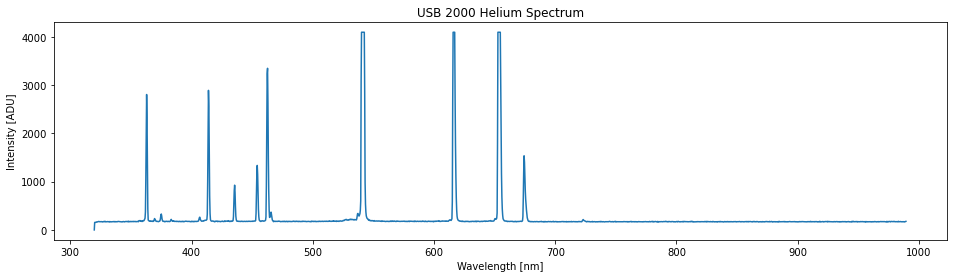

In [25]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(wl_x, int_He)         # Plot of helium spectrum using wavelength
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [ADU]')
plt.title('USB 2000 Helium Spectrum')

## KAST Spectrograph reduction:

In [26]:
data_dir = './Lab2Files/'  # Location of FITS files
data_files = np.array(sorted(os.listdir(data_dir)))  # List of all files

In [27]:
os.chdir(data_dir)  # Working in location where files are located

In [29]:
fnames = []

for i, val in enumerate(data_files):  # Specifying fits files in folder
    if val.endswith('.fits'):
        fnames.append(val)
        
fnames = np.array(fnames)     # Converting to Numpy array

In [31]:
bdata = fits.getdata(fnames[1])            # Extracting data (order known from collection)
fdata = fits.getdata(fnames[2]) - bdata    # Subtracting bias frames from each of the other three types
adata = fits.getdata(fnames[0]) - bdata
s1data = fits.getdata(fnames[-1]) - bdata
s2data = fits.getdata(fnames[-2]) - bdata

In [32]:
adata[adata > 65000] = 1    # Correcting for saturated pixels in arclamp and science frames
s1data[s1data > 65000] = 1
s2data[s2data > 65000] = 1

In [33]:
fnorm = fdata / np.median(fdata)  # Creating normalization factor
fnorm[fnorm == 0] = 1             # Correcting for 0's in normalizations factor to avoide dividing by 0

Text(0, 0.5, 'pixels(y)')

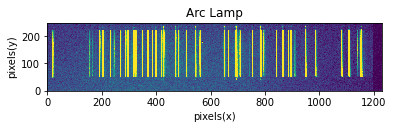

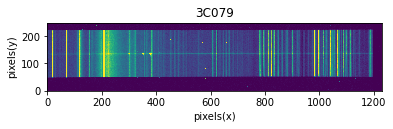

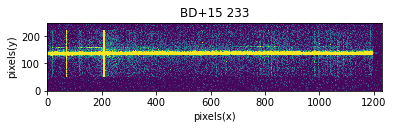

In [34]:
# Plotting images of final science and arclamp frames
# vmin and vmax for best resolution found by trial-and-error

aflat = adata / fnorm
plt.figure()
plt.imshow(adata,origin='lower',interpolation='nearest',cmap='viridis', vmin=0, vmax=200)
plt.title('Arc Lamp')
plt.xlabel('pixels(x)')
plt.ylabel('pixels(y)')

s1flat = s1data / fnorm
plt.figure()
plt.imshow(s1data,origin='lower',interpolation='nearest',cmap='viridis', vmin=0, vmax=750)
plt.title('3C079')
plt.xlabel('pixels(x)')
plt.ylabel('pixels(y)')

s2flat = s2data / fnorm
plt.figure()
plt.imshow(s2data,origin='lower',interpolation='nearest',cmap='viridis', vmin=0, vmax=50)
plt.title('BD+15 233')
plt.xlabel('pixels(x)')
plt.ylabel('pixels(y)')

In [35]:
s1spec = s1flat[135:165, 50:1200].sum(axis=0)  # Converting science and arclamp frames into 1D spectra for region
s2spec = s2flat[135:165, 50:1200].sum(axis=0)  #      with 30 central rows and with overscan edge columns removed
aspec = aflat[135:165, 50:1200].sum(axis=0)

Text(0.5, 1.0, 'BD+15 233 Spectrum')

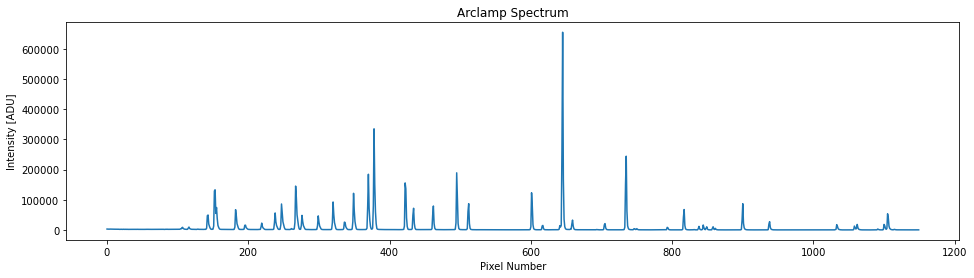

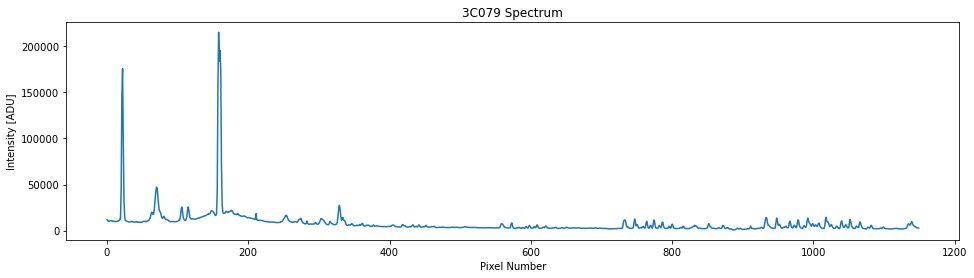

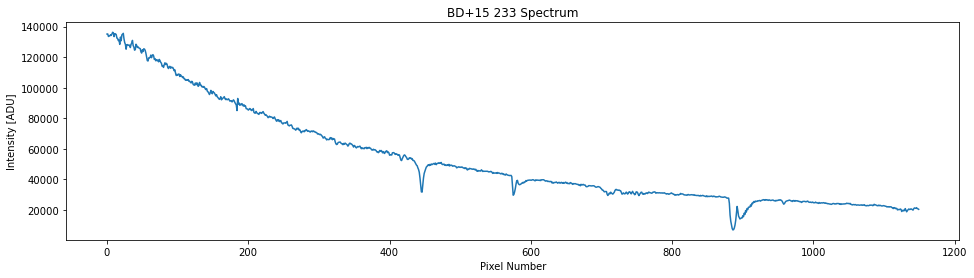

In [36]:
x = np.arange(1200-50)         # Defining x range to have size of overscan-removed region

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(x, aspec)              # Plot of arclamp spectrum with pixel numbers
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('Arclamp Spectrum')

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(x, s1spec)              # Plot of 3C079 spectrum with pixel numbers
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('3C079 Spectrum')

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(x, s2spec)              # Plot of BD+15 233 spectrum with pixel numbers
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('BD+15 233 Spectrum')

In [49]:
# Applying centroids routine to arclamp spectrum

mew = np.mean(aspec)
mask = np.where(aspec > mew, 1, 0)  # Using a mask to define peaks as having a mininmum height requirement of 2x
                                       # mean intensity in order to specify only the most prominent spectral features
pix_masked = []
tmp_peak = []
for i, mask_val in enumerate(mask):
    if mask_val == 1:
        tmp_peak.append((x[i], aspec[i]))  # List of pixel values and intensities
    elif len(tmp_peak) > 0:
            pix_masked.append(tmp_peak)        # Appending values where peak exists
            tmp_peak = []

In [50]:
centroids = []
sig_p = []

# Creating an array of centroid values for each peak

for peak in pix_masked:
    numerator = sum([a*b for a, b in peak])
    denom = sum([b for a, b in peak])
    x_c = numerator / denom
    centroids.append(x_c)
    
for i, peak in zip(centroids, pix_masked):
    errnum = sum([b*(a-i)**2 for a, b in peak])
    errdenom = sum([b for a, b in peak])
    err = errnum / errdenom
    sig_p.append(np.sqrt(err))
    
centroids = np.array(centroids)  # Converting centroids to an array for easier numpy operations
sig_p = np.array(sig_p)

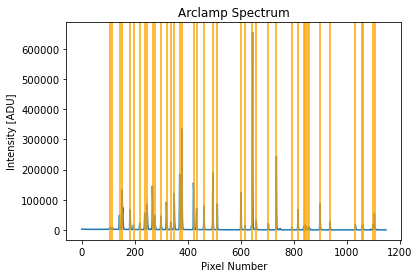

In [51]:
plt.figure()
plt.plot(x, aspec)
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('Arclamp Spectrum')
for i in centroids:
    plt.axvline(x = i, c = 'orange')  # Plot of centroids over arclamp spectrum

In [52]:
# Numpy arrays of researched wavelengths for helium, argon, mercury, and neon for linear least squares fit

wl_He = [394., 416., 427., 441., 469., 502., 589., 668., 710.] 
# https://edisciplinas.usp.br/pluginfile.php/4822251/mod_resource/content/1/Espectro%20do%20helio%20-%20presto.pdf
wl_He = np.array(wl_He)

wl_Ar = [351.1, 363.8, 454.6, 457.9, 465.8, 476.5, 488.0, 496.5, 501.7, 514.5, 528.7] 
# https://en.wikipedia.org/wiki/Ion_laser
wl_Ar = np.array(wl_Ar)

wl_Hg = [404.7, 407.8, 435.8, 546.1, 576.9, 579.1] 
# http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/atspect2.html
wl_Hg = np.array(wl_Hg)

wl_Ne = [540.1, 585.2, 588.2, 603, 607.4, 616.4, 621.7, 626.6, 633.4, 638.3, 640.2, 650.6, 659.9, 692.9, 703.2]
# http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/atspect2.html
wl_Ne = np.array(wl_Ne)

In [53]:
wl_tot = np.concatenate([wl_He, wl_Ar, wl_Hg, wl_Ne], axis=0) # Combining all wavelengths in arclamp
wl_tot = np.sort(wl_tot)                                      # Sorting wavelength array into numerical order

In [54]:
N = len(centroids)     # Number of centroid values for N input

M1 = np.array([[np.sum((centroids)**2), np.sum(centroids)],[np.sum(centroids), N]])  # First matrix on right hand side
M2 = np.array([[np.sum(centroids*wl_tot)],[np.sum(wl_tot)]])  # Second matrix on right hand side

In [55]:
M1_inv = np.linalg.inv(M1)  # Inverse of first matrix
M = np.dot(M1_inv, M2)      # Dot product of two matrices for final result matrix

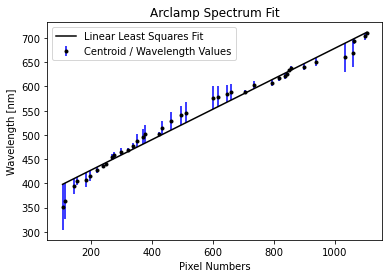

In [56]:
mfit = M[0,0]                           # Slope value from final matrix
cfit = M[1,0]                           # Intercept value from final matrix
y = [mfit*a + cfit for a in centroids]  # Linear least squares best-fit line
xerr = sig_p**2                         # Centroid standard deviation
yerr = np.absolute(y - wl_tot)          # Error of each point from the best-fit line

plt.errorbar(centroids, wl_tot, yerr=yerr, fmt='.', mfc='k', mec='k', ecolor='b', label = 'Centroid / Wavelength Values')
plt.plot(centroids, y, 'k' , label='Linear Least Squares Fit')

# Fit line plotted over centroid points to check linear least squares fit
    
plt.title('Arclamp Spectrum Fit')
plt.ylabel('Wavelength [nm]')
plt.xlabel('Pixel Numbers')
plt.legend()

In [58]:
print('Average std. dev. in x:', np.mean(xerr))  # Average standard deviations
print('Average std. dev. in y:', np.mean(yerr))

Average std. dev. in x: 0.6205804174578609
Average std. dev. in y: 12.257797360858882


In [59]:
sig = np.sqrt(1/(N-2) * np.sum((wl_tot - y)**2))
print('Gaussian std. dev. of fit:', sig**2)  # Overall Gaussian standard deviation of fit

Gaussian std. dev. of fit: 263.7103667315315


In [62]:
sig_M = np.sqrt((N*sig**2) / ((N*np.sum((centroids)**2))-(np.sum(centroids))**2))
print('Std. dev. of slope:', sig_M**2)  # Slope standard deviation

Std. dev. of slope: 6.703785919071916e-05


In [63]:
sig_c = np.sqrt((sig**2*np.sum((centroids)**2)) / ((N*np.sum((centroids)**2))-(np.sum(centroids))**2))
print('Std. dev. of intercept:', sig_c**2)  # Intercept standard deviation

Std. dev. of intercept: 26.95653351788384


In [64]:
wl_final = []

for i in x:             # Creating array of converted wavelengths
    w = pix_to_wl(i)
    wl_final.append(w)

Text(0.5, 1.0, 'BD+15 233 Spectrum')

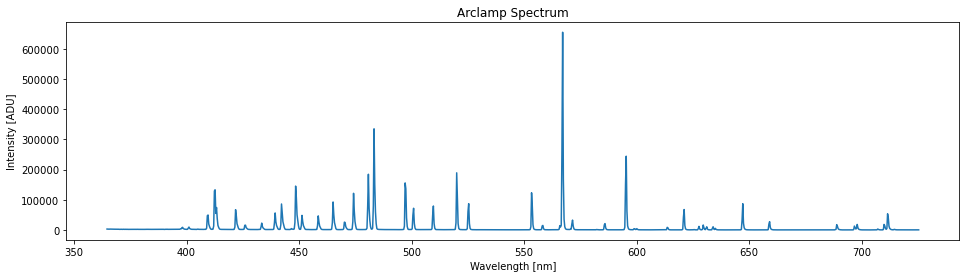

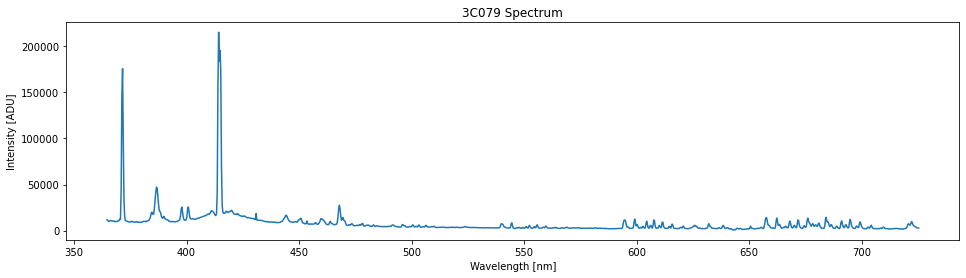

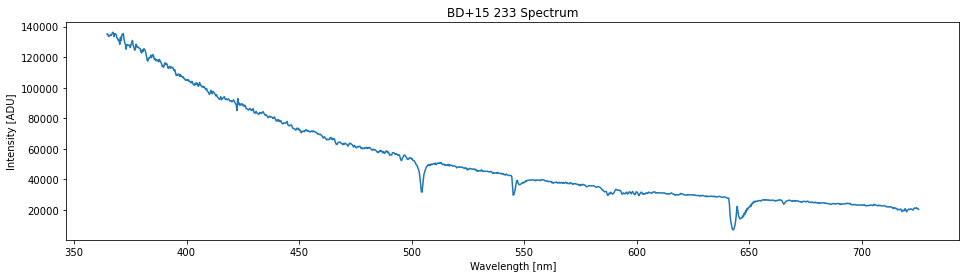

In [65]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(wl_final, aspec)         # Plot of arclamp spectrum using wavelength solution
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [ADU]')
plt.title('Arclamp Spectrum')

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(wl_final, s1spec)         # Plot of 3C079 spectrum using wavelength solution from arclamp
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [ADU]')
plt.title('3C079 Spectrum')

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(wl_final, s2spec)         # Plot of BD+15 233 spectrum using wavelength solution from arclamp
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [ADU]')
plt.title('BD+15 233 Spectrum')

In [66]:
# Finding peaks in final spectrum of 3C079

mew = np.mean(s1spec)
mask = np.where(s1spec > mew*5, 1, 0)  # Using a mask to define peaks as having a mininmum height requirement of 5x
                                       # mean intensity in order to specify only the most prominent spectral features
pix_masked = []
tmp_peak = []
for i, mask_val in enumerate(mask):
    if mask_val == 1:
        tmp_peak.append((wl_final[i], wl_final[i]))  # List of pixel values and intensities
    elif len(tmp_peak) > 0:
            pix_masked.append(tmp_peak)        # Appending values where peak exists
            tmp_peak = []

In [67]:
centroids = []
sig_p = []

# Creating an array of centroid values for each peak

for peak in pix_masked:
    numerator = sum([a*b for a, b in peak])
    denom = sum([b for a, b in peak])
    x_c = numerator / denom
    centroids.append(x_c)
    
for i, peak in zip(centroids, pix_masked):
    errnum = sum([b*(a-i)**2 for a, b in peak])
    errdenom = sum([b for a, b in peak])
    err = errnum / errdenom
    sig_p.append(np.sqrt(err))
    
centroids = np.array(centroids)  # Converting centroids to an array for easier numpy operations
sig_p = np.array(sig_p)

print(centroids)  # Printing centroids and error for comparison to experiment
print(sig_p)

[371.40096049 386.62649158 414.56720374]
[0.35098628 0.25632419 0.6278629 ]


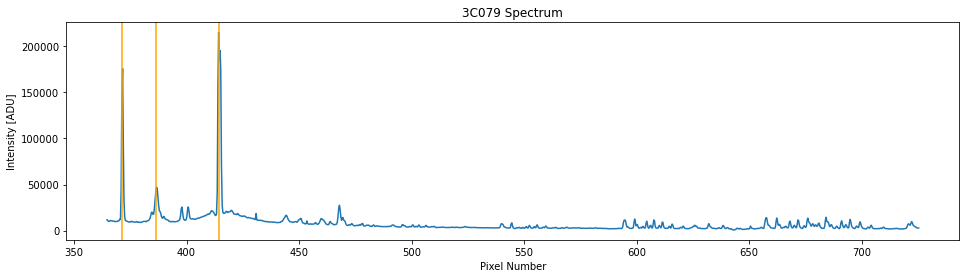

In [68]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(wl_final, s1spec)
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('3C079 Spectrum')
for i in centroids:
    plt.axvline(x = i, c = 'orange')  # Plot of centroids over 3C079 spectrum

In [70]:
raw_mins = []  # Finding minima in BD+15 233 spectrum
sig_p = []
index = 0

for i in np.diff(np.sign(np.diff(s2spec))):
    index += 1
    if i > 0 and s2spec[index - 10] > s2spec[index + 1] < s2spec[index + 4]:
        raw_mins.append(wl_final[index + 1])
        
for i, a, b in zip(raw_mins, wl_final, s2spec):
    errnum = sum([b*(a-i)**2])
    errdenom = sum([b])
    err = errnum / errdenom
    sig_p.append(np.sqrt(err))
    
raw_mins = np.array(raw_mins)  # Converting centroids to an array for easier numpy operations
sig_p = np.array(sig_p)

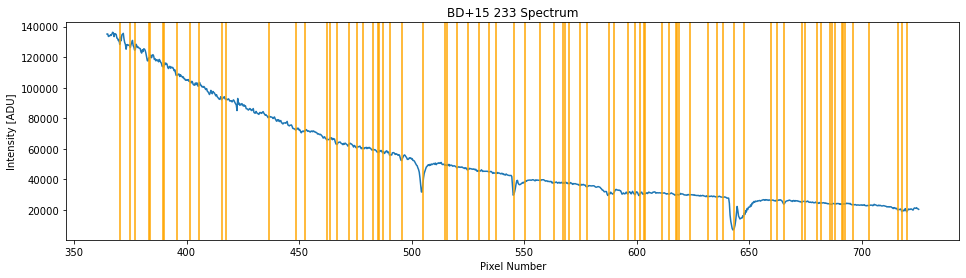

In [71]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)
plt.plot(wl_final, s2spec)
plt.xlabel('Pixel Number')
plt.ylabel('Intensity [ADU]')
plt.title('BD+15 233 Spectrum')
for i in raw_mins:
    plt.axvline(x = i, c = 'orange')  # Plot of centroids over BD+15 233 spectrum

In [72]:
#Finding locations of visually selected peaks; first after 500, last before 550, and second to last before 650

print('Pixel value =', raw_mins[27], ', Intensity =', sig_p[27])
print('Pixel value =', raw_mins[35], ', Intensity =', sig_p[35])
print('Pixel value =', raw_mins[60], ', Intensity =', sig_p[60])

Pixel value = 504.9786144720918 , Intensity = 131.85136071519952
Pixel value = 545.4758181203317 , Intensity = 169.83710987362616
Pixel value = 643.1086114118247 , Intensity = 259.62160788445243
